## Dependencias

In [2]:
import pandas as pd
import numpy as np

import datetime as datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier

import seaborn as sns

## Lectura de datos

In [3]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/Fraud.csv'

In [4]:
df = pd.read_csv(ruta)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [5]:
df.shape

(6362620, 11)

## Análisis exploratorio

### Balanceo de muestra

In [6]:
df = pd.concat([d.sample(8213).reset_index(drop=True).assign(isFraud=t) for t,d in df.groupby('isFraud')],
                   ignore_index=True)

### Valores nulos

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<AxesSubplot:>

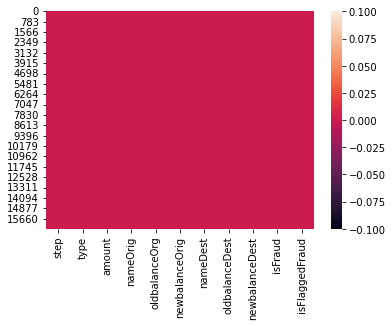

In [8]:
sns.heatmap(df.isnull(), cbar= True)

### Tipo de dato

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16426 entries, 0 to 16425
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            16426 non-null  int64  
 1   type            16426 non-null  object 
 2   amount          16426 non-null  float64
 3   nameOrig        16426 non-null  object 
 4   oldbalanceOrg   16426 non-null  float64
 5   newbalanceOrig  16426 non-null  float64
 6   nameDest        16426 non-null  object 
 7   oldbalanceDest  16426 non-null  float64
 8   newbalanceDest  16426 non-null  float64
 9   isFraud         16426 non-null  int64  
 10  isFlaggedFraud  16426 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 1.4+ MB


## Selección de variables

In [10]:
vt = ['isFraud']
var_num = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
          'newbalanceDest']

## Partición

In [11]:
Xt, Xv, yt, yv = train_test_split(df[var_num], df[vt[0]], train_size= 0.7)
Xt.reset_index(drop = True, inplace = True)
Xv.reset_index(drop = True, inplace = True)
yt.reset_index(drop = True, inplace = True)
yv.reset_index(drop = True, inplace = True)

## Aprendizaje

### Hiperparámetros

In [12]:
hp = dict(max_iter = range(100,200),
         fit_intercept = [True, False],
         C = np.arange(0.1,3,0.1))

In [13]:
modelo = PassiveAggressiveClassifier()

### Hiperparametrización

In [14]:
grid = GridSearchCV(param_grid= hp,
                   cv = 3,
                   scoring= 'accuracy',
                   n_jobs= -1,
                   verbose = True,
                   estimator = modelo)

## Entrenamiento

In [15]:
grid.fit(Xt, yt)

Fitting 3 folds for each of 5800 candidates, totalling 17400 fits


GridSearchCV(cv=3, estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                         'fit_intercept': [True, False],
                         'max_iter': range(100, 200)},
             scoring='accuracy', verbose=True)

### Mejores parámetros

In [16]:
grid.best_params_

{'C': 2.6, 'fit_intercept': False, 'max_iter': 111}

In [17]:
modelo = grid.best_estimator_
modelo

PassiveAggressiveClassifier(C=2.6, fit_intercept=False, max_iter=111)

## Validación del modelo

### Probabilidad

In [18]:
print(accuracy_score(y_pred= modelo.predict(Xt), y_true = yt))
print(accuracy_score(y_pred= modelo.predict(Xv), y_true = yv))

0.9112019481648982
0.916801948051948


### Matriz de confusión

In [19]:
print(confusion_matrix(y_pred= modelo.predict(Xt), y_true = yt))
print(confusion_matrix(y_pred= modelo.predict(Xv), y_true = yv))

[[4995  777]
 [ 244 5482]]
[[2145  296]
 [ 114 2373]]


## Predicciones

In [20]:
df['Pred'] = modelo.predict(df[var_num])
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,Pred
0,155,PAYMENT,15936.52,C2103039810,613005.91,597069.39,M501641488,0.00,0.00,0,0,0
1,330,PAYMENT,24797.05,C542707600,0.00,0.00,M131207342,0.00,0.00,0,0,0
2,275,PAYMENT,4908.23,C572239914,60699.89,55791.66,M1716173807,0.00,0.00,0,0,0
3,277,TRANSFER,798981.71,C1950987066,15157.00,0.00,C1770568337,963116.67,1762098.38,0,0,0
4,301,CASH_OUT,15152.41,C842421582,102363.00,87210.59,C864853229,4982495.98,4997648.40,0,0,0
